In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# -----------------------------
# Step 1: Generate Synthetic Tourist Paths
# -----------------------------

np.random.seed(42)

def generate_normal_path(length=30, start=(12.9, 77.6)):
    """
    Generate a normal tourist path (smooth lat/lon progression)
    """
    lat, lon = start
    path = []
    for i in range(length):
        lat += np.random.normal(0.0005, 0.0002)  # small movements
        lon += np.random.normal(0.0005, 0.0002)
        safety_score = np.clip(np.random.normal(0.7, 0.1), 0, 1)  # mostly safe
        path.append([lat, lon, safety_score])
    return np.array(path)

def generate_anomaly_path(length=30, start=(12.9, 77.6), anomaly_type="deviation"):
    """
    Generate anomalous tourist paths:
    - deviation: sudden big jump
    - stall: no movement for a while
    - loop: stuck in unsafe zone
    """
    path = generate_normal_path(length, start)

    if anomaly_type == "deviation":
        # sudden jump far away
        jump_idx = np.random.randint(10, 20)
        path[jump_idx:, 0] += 0.05
        path[jump_idx:, 1] += 0.05

    elif anomaly_type == "stall":
        stall_idx = np.random.randint(10, 20)
        path[stall_idx:] = path[stall_idx]  # no movement

    elif anomaly_type == "loop":
        loop_idx = np.random.randint(10, 20)
        path[loop_idx:, 0] = path[loop_idx, 0] + np.sin(np.linspace(0, 10, length - loop_idx)) * 0.001
        path[loop_idx:, 1] = path[loop_idx, 1] + np.cos(np.linspace(0, 10, length - loop_idx)) * 0.001
        path[loop_idx:, 2] = np.clip(np.random.normal(0.2, 0.05, length - loop_idx), 0, 1)  # unsafe zone

    return path


In [ ]:


# Create dataset
normal_paths = np.array([generate_normal_path() for _ in range(500)])
anomaly_paths = np.array([generate_anomaly_path(anomaly_type=np.random.choice(["deviation", "stall", "loop"]))
                          for _ in range(50)])

X_train = normal_paths
X_test = np.concatenate([normal_paths[:50], anomaly_paths])

# -----------------------------
# Step 2: Preprocessing
# -----------------------------

# Flatten for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_flat = X_train.reshape(-1, 3)
X_test_flat = X_test.reshape(-1, 3)

scaler.fit(X_train_flat)

X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

time_steps = X_train.shape[1]
features = X_train.shape[2]


In [ ]:

# -----------------------------
# Step 3: Build LSTM Autoencoder
# -----------------------------

inputs = Input(shape=(time_steps, features))

# Encoder
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
encoded = layers.Dense(16, activation="relu")(x)

# Decoder
x = layers.RepeatVector(time_steps)(encoded)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
decoded = layers.TimeDistributed(layers.Dense(features))(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=20,
                          batch_size=32,
                          validation_split=0.2,
                          verbose=1)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.2054 - val_loss: 0.0386
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0312 - val_loss: 0.0211
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0215 - val_loss: 0.0179
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0174 - val_loss: 0.0154
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0133 - val_loss: 0.0123
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0

In [ ]:

# -----------------------------
# Step 4: Anomaly Detection
# -----------------------------

# Reconstruct test sequences
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.mean(np.square(X_test_scaled - reconstructions), axis=2), axis=1)

# Set threshold
threshold = np.percentile(mse, 95)  # top 5% errors are anomalies

# Labels
labels = np.array([0]*50 + [1]*50)  # 0=normal, 1=anomaly
preds = (mse > threshold).astype(int)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step


Threshold: 2.3118483603685434
[[50  0]
 [45  5]]
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        50
           1       1.00      0.10      0.18        50

    accuracy                           0.55       100
   macro avg       0.76      0.55      0.44       100
weighted avg       0.76      0.55      0.44       100



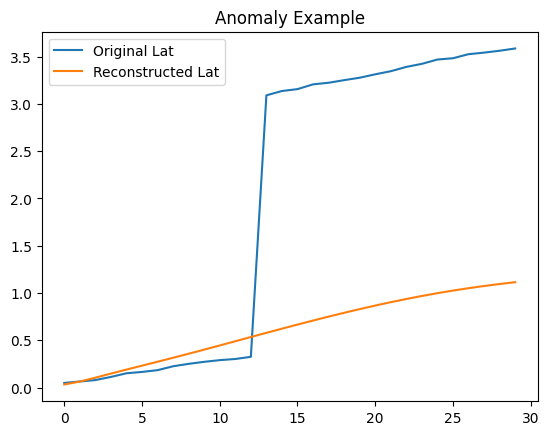

In [ ]:

# -----------------------------
# Step 5: Evaluation
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix

print("Threshold:", threshold)
print(confusion_matrix(labels, preds))
print(classification_report(labels, preds))

# Plot sample anomaly vs reconstruction
i = 60  # pick an anomaly
plt.plot(X_test_scaled[i,:,0], label="Original Lat")
plt.plot(reconstructions[i,:,0], label="Reconstructed Lat")
plt.legend()
plt.title("Anomaly Example")
plt.show()
